# Aggregating and Learning from Multiple Annotators: Practical

This part of the tutorial has the following goals:
   * Learn to use Dawid and Skene (1979) models to aggregate classifications from a crowd.
   * Understand the effect of key hyperparameters in the above models.
   * Learn how to train a downstream model directly from crowdsourced annotations using the CrowdLayer (Rodrigues and Pereira, 2018).
   <!-- * Learn to apply Bayesian sequence combination (BSC) to aggregate sequence labels from crowds (Simpson and Gurevych 2019). (this needs the NER dataset or something similar) --> 
   
As an example dataset, we will work with crowdsourced annotations for the _recognising textual entailment (RTE)_ task. This dataset is the PASCAL RTE-1 corpus containing 800 text-hypothesis pairs for which gold annotations were provided by Dagan et al. (2006). Snow et al. (2008) produced the crowdsourced dataset for the corpus:  164 annotators produced 10 annotations for each sentence-pair. 


> Ido  Dagan,  Oren  Glickman,  and  Bernardo  Magnini.2006.  The PASCAL recognising textual entailmentchallenge.In  Juan  Qui ̃nonero-Candela,  Ido  Da-gan, Bernardo Magnini, and F. d’Alch ́e Buc, editors,MLCW 2005, number 3944 in LNAI, pages 177–190.Springer.

> Rion Snow,  Brendan O’Connor,  Daniel Jurafsky,  andAndrew  Y.  Ng.  2008.    Cheap  and  fast  -  but  is  itgood? evaluating non-expert annotations for naturallanguage tasks. InProc. of EMNLP, pages 254–263.

First, we apply a variational Bayesian variant of Dawid & Skene's 1979 method to infer the true labels independently. Then, we train classifiers with both aggregated labels and the raw crowdsourced labels using the CrowdLayer method.

## Importing Required PackagesTo run this notebook, please checkout the whole [Github repository](https://github.com/UKPLab/arxiv2018-bayesian-ensembles/) and run it within that directory.

In [23]:
# pick up any changes to the imported modules automatically
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_curve, log_loss
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.stats import beta

import logging
logging.basicConfig(level=logging.DEBUG)

# code included in this directory:
import sys
sys.path.append('src')
from bayesian_combination.ibcc import IBCC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the Data

   1. Download the [text data from here](https://sites.google.com/site/nlpannotations/snow2008_mturk_data_with_orig_files_assembled_201904.zip?attredirects=0) 
   1. Download [the crowd labels from here](https://sites.google.com/site/nlpannotations/all_collected_data.tgz?attredirects=0) 
   1. Unzip the files. 
   1. Place the unzipped directories inside the directory containing this notebook.

The following code should show that the data folders 'snow2008_mturk_data_with_orig_files_assembled_201904' and 'all_collected_data' are in the current directory and the 'rte' folder is inside 'snow2008_mturk_data_with_orig_files_assembled_201904'.

In [5]:
print(os.listdir('.'))
print(os.listdir('./snow2008_mturk_data_with_orig_files_assembled_201904'))

rte_text_dir = './snow2008_mturk_data_with_orig_files_assembled_201904/rte'
rte_text_file = os.path.join(rte_text_dir, 'rte1.tsv')
rte_anno_file = './all_collected_data/rte.standardized.tsv'

['setup.sh', 'snow2008_mturk_data_with_orig_files_assembled_201904', 'crowd_layer', 'batch_scripts', '.DS_Store', 'LICENSE', 'requirements.txt', 'config', 'aggregation_tutorial.ipynb', 'output', 'README.md', 'requirements_expts.txt', 'NOTICE.txt', '.gitignore', '.project', '.pydevproject', '.ipynb_checkpoints', 'documents', 'all_collected_data', '.git', 'setup_with_expts.sh', 'data', 'glove.6B', '.idea', 'src']
['.DS_Store', 'tempeval', 'all_collected_data.tgz', 'rte', 'README.txt', 'affect_emotion']


In [6]:
# Load the text.
textdata = pd.read_csv(
    rte_text_file, 
    sep='\t', 
    usecols=[0, 1, 3, 4], 
    index_col=0, 
    names=['item_id', 'gold', 'text', 'hypothesis'],
    skiprows=1
)

# Load the crowdsourced data
crowddata = pd.read_csv(
    rte_anno_file, 
    sep='\t', 
    usecols=[0, 1, 2, 3],
    index_col=0,
    names=['annotation_id', 'worker', 'item_id', 'label'],
    skiprows=1
)
print(textdata)
print(crowddata)

          gold                                               text  \
item_id                                                             
754       True  Mexico City has a very bad pollution problem b...   
822       True                 Satomi Mitarai died of blood loss.   
692       True  The national insurrection of 1794, led by Tade...   
731      False  The city Tenochtitlan grew rapidly and was the...   
1865     False  Militant groups in Iraq have waged a kidnappin...   
...        ...                                                ...   
1062      True  A former petty thief who converted and founded...   
997      False  One of Michigan&apos;s largest newspaper chain...   
1835     False  The new arrivals followed a similar number tha...   
2124     False  Fighters loyal to Moqtada al-Sadr shot down a ...   
1122      True  Continuing its buying spree, IBM said Wednesda...   

                                                hypothesis  
item_id                                  

In [7]:
# Put the gold data into a vector
num_items = np.max(textdata.index) + 1

gold_labels = np.zeros(num_items)
gold_labels[textdata.index] = textdata["gold"].astype(int)

print(np.sum(gold_labels==0))
print(np.sum(gold_labels==1))

1791
400


In [8]:
# Convert the Amazon MT worker IDs to consecutive numbers
uworkers, worker_ids = np.unique(crowddata["worker"], return_inverse=True)
num_workers = np.max(worker_ids) + 1

# Put the crowdsourced data into matrix format
crowd_matrix = np.zeros((num_items, num_workers)) - 1  # use -1 to indicate missing labels

# fill the matrix
crowd_matrix[crowddata["item_id"].astype(int), worker_ids] = crowddata["label"].astype(int)

print(crowd_matrix)
print(np.sum(crowd_matrix == 0))
print(np.sum(crowd_matrix == 1))

# limit the number of labels per data point to 5
def reduce_num_annotations(crowd_matrix, max_workers_per_item):
    for i in range(num_items):
        row = crowd_matrix[i, :]
        available = np.argwhere(row > -1).flatten()
        if len(available) > max_workers_per_item:
            to_be_removed = available[max_workers_per_item:]
            crowd_matrix[i, to_be_removed] = -1
            
    return crowd_matrix

max_workers_per_item = 3
crowd_matrix = reduce_num_annotations(crowd_matrix, max_workers_per_item)

print(np.unique(np.sum(crowd_matrix > -1, axis=1)))

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 1.  0. -1. ... -1. -1. -1.]]
3419
4581
[0 3]


Let's test some baselines. Firstly, the majority class baseline, then the majority vote.

In [9]:
baseline_predictions = np.zeros(num_items)

total_votes = np.sum(crowd_matrix != -1, axis=1)
votes = np.zeros(num_items)
votes[total_votes > 0] = np.sum(crowd_matrix == 1, axis=1)[total_votes > 0] / total_votes[total_votes > 0].astype(float)

mv_predictions = np.zeros(num_items, dtype=int)
mv_predictions[(total_votes > 0) & (votes>0.5)] = 1

Write a function to compute and show some performance metrics:

In [10]:
def show_metrics(gold_labels, prob_class_1, predicted_labels, method_names):
    
    for m, method_name in enumerate(method_names):
        print('Method = {}'.format(method_name))
        
        acc = accuracy_score(gold_labels, predicted_labels[m])
        print('Accuracy = {}'.format(acc))
    
        f1 = f1_score(gold_labels, predicted_labels[m])
        print('F1 score = {}'.format(f1))
        
        ll = log_loss(gold_labels, prob_class_1[m])
        print('Cross entropy error = {}'.format(ll))
        
        
show_metrics(
    gold_labels, 
    [baseline_predictions, votes], 
    [baseline_predictions, mv_predictions], 
    ['majority class', 'majority_vote']
)

Method = majority class
Accuracy = 0.8174349612049293
F1 score = 0.0
Cross entropy error = 6.305573052471144
Method = majority_vote
Accuracy = 0.8808763121862163
F1 score = 0.7350253807106599
Cross entropy error = 0.8875545165727721


## Dawid & Skene (IBCC-VB)

The model we run here is IBCC-VB, which is a modification to the Dawid & Skene (1979) model. The [repository is available here](https://github.com/ukplab/arxiv2018-bayesian-ensembles). For a recap of the model, please [see the tutorial slides](https://sites.google.com/view/alma-tutorial) or the description in [Paun et al. (2018), Comparing Bayesian Models of Annotation](https://transacl.org/ojs/index.php/tacl/article/view/1430).



IBCC-VB differs from the original Dawid & Skene method in the following ways:
   * The parameters have prior distributions -- it is a Bayesian treatment of the model.
   * Approximate inference is performed using variational Bayes instead of maximum likelihood EM.
This has some benefits: 
   * We can include prior information about labeller reliability and class imbalances. This is particularly useful when to avoid the nonidentifiability problem of unsupervised methods by encoding the prior belief that labellers are more likely to give correct answers than incorrect ones.
   * The inference method integrates over unknown parameters, reducing the influence of workers who are known with less confidence. For example, if a worker labels two data points and gets them right, how strongly do we trust them on a third data point? Usually, we would not be very conifdent of their reliability despite a 100% accuracy record.  We may even trust them less than someone who labelled 1000 data points and got 900 right. Bayesian inference takes care of this, whereas maximum likelihood estimation can be led astray by workers who have completed few tasks.

### Run IBCC with a Matrix of Annotations

In [11]:
ibcc_model = IBCC(
    L=2, # number of classes
    K=num_workers, 
)

# Run inference to obtain an array of size num_data_points x num_classes containing the probabilities of the true labels
posterior, predictions, _ = ibcc_model.fit_predict(crowd_matrix)

# Compare with the ground truth
show_metrics(
    gold_labels, 
    [baseline_predictions, votes, posterior[:, 1]], 
    [baseline_predictions, mv_predictions, predictions], 
    ['majority class', 'majority_vote', 'IBCC-VB']
)

Parallel can run 8 jobs simultaneously, with 8 cores
[[2. 1.]
 [1. 2.]]
Method = majority class
Accuracy = 0.8174349612049293
F1 score = 0.0
Cross entropy error = 6.305573052471144
Method = majority_vote
Accuracy = 0.8808763121862163
F1 score = 0.7350253807106599
Cross entropy error = 0.8875545165727721
Method = IBCC-VB
Accuracy = 0.939297124600639
F1 score = 0.8372093023255813
Cross entropy error = 0.5515550944818187


## Evaluating Annotators

The IBCC-VB model learns a 'confusion matrix' parameter for each annotator. This parameter describes the reliability of the worker. IBCC-VB provides the expected value of this parameter, as shown in the code below. Each row of the matrix is the likelihood distribution of the annotator's labels given the ground truth. High values on the diagonals indicate an accurate worker.

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 500 normal>) = 2.872272727272727
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactTextItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukta Mahee' (MuktaMahee.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:m

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manag

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sana' (Sana.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 40

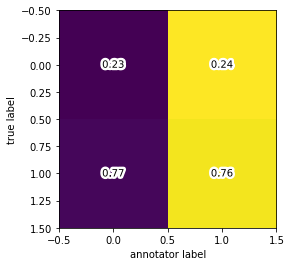

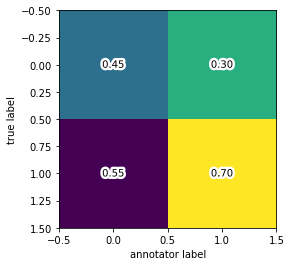

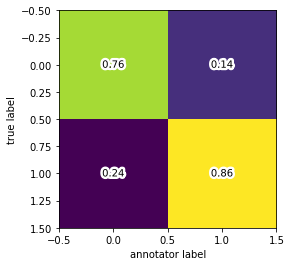

In [12]:
# print the confusion matrix for worker i

ibcc_model.informativeness()

def plot_confusion_matrix(model, annotator_idx):
    
    # compute the expected confusion matrix by normalising the alpha variational parameter
    E_conf_mat = model.A.alpha[:, :, annotator_idx] / np.sum(model.A.alpha[:, :, annotator_idx], axis=1)[:, None]
    
    plt.figure()
    plt.imshow(E_conf_mat)
    
    min_val, max_val = 0, model.L
    ind_array_rows = np.arange(min_val, max_val, 1)
    
    min_val, max_val = 0, model.L
    ind_array_cols = np.arange(min_val, max_val, 1)
    
    x, y = np.meshgrid(ind_array_rows, ind_array_cols)

    for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
        text = "%.2f" % E_conf_mat[x_val, y_val]
        txt = plt.text(x_val, y_val, text, va='center', ha='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        
    plt.xlabel('annotator label')
    plt.ylabel('true label')

        
# Show the results with a selection of annotators:
plot_confusion_matrix(ibcc_model, 0)
plot_confusion_matrix(ibcc_model, 1)
plot_confusion_matrix(ibcc_model, 2)

If we need a single value to assess an annotator's competence, we can compute the mutual information (MI) between the annotators' labels and the ground truth. This value uses information theory to quantify how much we learn about the true label from an annotator's label. In other words the information gain (IG) from the annotation.

Assuming an unlabelled data point, the information gain about a label $c_i$ from annotator $n$'s label, $y_{i,n}$ is:

$$
I(c_i; y_{i,n}) = H(c_{i}) - H(y_{i,n} | c_i) \\
= \sum_{j=1}^J\left\{ - p(c_i=j) \ln p(c_i=j) + \sum_{k=1}^J p(y_{i,n}=k)p(c_i=j | y_{i,n}=k) \ln p(c_i=j | y_{i,n}=k) \right\} \\
= \sum_{j=1}^J \left\{ - p(c_i=j) \ln p(c_i=j) + \sum_{k=1}^J p(y_{i,n}=k | c_i=j)p(c_i=j) \ln \frac{p(y_{i,n}=k | c_i=j)p(c_i=j)}{\sum_{l=1}^J p(y_{i,n}=l | c_i=j)p(c_i=j)} \right\}
$$

where $J$ is the number of classes and $H$ is entropy.

This function is already implemented in the BayesianCombination library:

Annotator 8 has informativeness score of 0.5108816402385874
Annotator 16 has informativeness score of 0.3472407324046234
Annotator 20 has informativeness score of 0.3267822090795855
Annotator 10 has informativeness score of 0.3238879988254529
Annotator 12 has informativeness score of 0.318768899455469


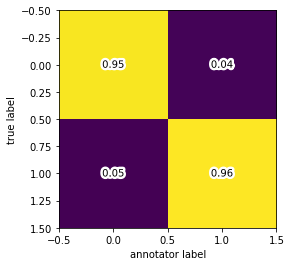

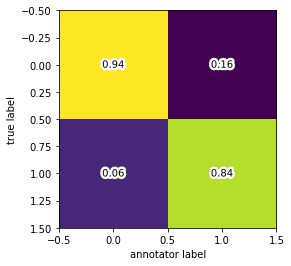

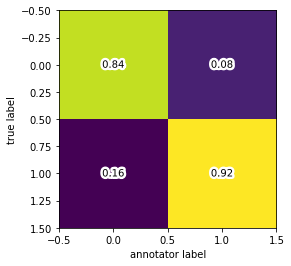

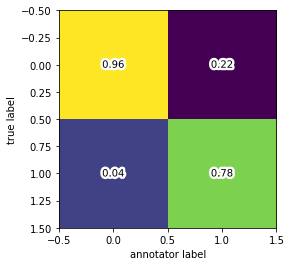

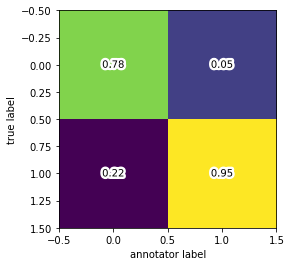

In [13]:
I = ibcc_model.informativeness()  # get a list of informativeness scores for all annotators

ranks = np.flip(np.argsort(I))  # sort in descending order

# Print the top annotators' scores and confusion matrices
for i in range(5):
    print("Annotator {} has informativeness score of {}".format(ranks[i], I[ranks[i]]))
    plot_confusion_matrix(ibcc_model, ranks[i])

### Adjusting the hyperparameters

In IBCC, each worker has a confusion matrix parameter for each worker that determines the likelihood of the worker labels given the true classes. Each row of this matrix, $\boldsymbol\pi_j$, contains the probabilities of a categorical distribution for the case when the true label has value $j$. These probabilities have a Dirichlet prior distribution, $\boldsymbol\pi_j \sim Dirichlet(\boldsymbol\alpha_{0,j})$. The hyperparameter vectors $\boldsymbol\alpha_{0,j}$ are rows of the hyperparameter matrix, $\boldsymbol\alpha$.

By default, the IBCC code sets the values in $\boldsymbol\alpha$ to $1$ on the off-diagonals and 2 on the diagonals. Larger values on the diagonals increase the probability that workers tend to give the right answer, because the diagonals correspond to giving correct answers.

However, we can set $\boldsymbol\alpha$ to any suitable values for a particular domain. 

The model also has a hyperparameter $\boldsymbol\beta_0$ that also parametrises a Dirichlet distribution over the class prior. Adjusting this encodes the prior belief in the balance between the two classes.

To understand the effects of $\boldsymbol\alpha_0$ and $\boldsymbol\beta_0$, let's first visualise the Dirichlet distribution to see how it maps $\boldsymbol\alpha_{0,j}$ to a distribution over probabilities. In our use case, we have only two classes, so we can work with the binary special case of the Dirichlet known as the Beta distribution. For the binary case, we compute the probability density function over p(class 1) only, since p(class 0) = 1 - p(class 1).

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Display' (ArabicUIDisplay.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic norma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 500 normal>) = 2.872272727272727
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 100 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactTextItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mukta Mahee' (MuktaMahee.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXVariants' (STIXVar.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam Sangam MN' (Malayalam Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 500 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer Sangam MN' (Khmer Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:m

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal 300 normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 5 normal>) = 10.42525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manag

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sana' (Sana.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal 900 normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal 600 condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 40

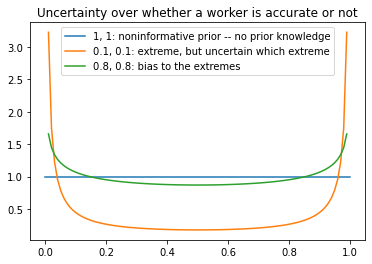

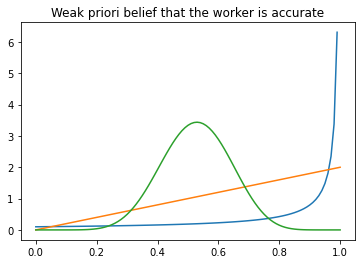

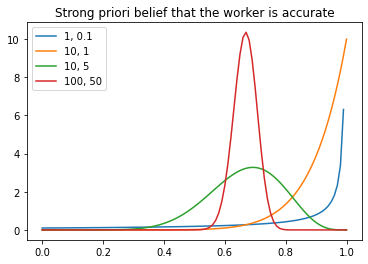

In [14]:
#First, let's plot some beta distriutions for different parameters:

plt.figure()
plt.title('Uncertainty over whether a worker is accurate or not')

x = np.arange(101) / 100.0
y = beta.pdf(x, 1, 1)
plt.plot(x,y, label='1, 1: noninformative prior -- no prior knowledge')

y = beta.pdf(x, 0.1, 0.1)
plt.plot(x,y, label='0.1, 0.1: extreme, but uncertain which extreme')

y = beta.pdf(x, 0.8, 0.8)
plt.plot(x,y, label='0.8, 0.8: bias to the extremes')

plt.legend(loc='best')


plt.figure()
plt.title('Weak priori belief that the worker is accurate')

y = beta.pdf(x, 1, 0.1)
plt.plot(x,y, label='1, 1.1')

y = beta.pdf(x, 2, 1)
plt.plot(x,y, label='1, 2')

y = beta.pdf(x, 10, 9)
plt.plot(x,y, label=', 5')


plt.figure()
plt.title('Strong priori belief that the worker is accurate')

y = beta.pdf(x, 1, 0.1)
plt.plot(x,y, label='1, 0.1')

y = beta.pdf(x, 10, 1)
plt.plot(x,y, label='10, 1')

y = beta.pdf(x, 10, 5)
plt.plot(x,y, label='10, 5')

y = beta.pdf(x, 100, 50)
plt.plot(x,y, label='100, 50')

plt.legend(loc='best')

Now, we can plot performance (prec, rec, f1) as we vary $\boldsymbol\alpha_0$ then $\boldsymbol\beta_0$. To reduce the number of hyperparameters we have to vary, we are going to consider just two values: a value that is first assigned to all entries, and a value that is added to all diagonals.

Parallel can run 8 jobs simultaneously, with 8 cores
[[0.02 0.01]
 [0.01 0.02]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[0.11 0.01]
 [0.01 0.11]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[1.01 0.01]
 [0.01 1.01]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[1.001e+01 1.000e-02]
 [1.000e-02 1.001e+01]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[1.0001e+02 1.0000e-02]
 [1.0000e-02 1.0001e+02]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[0.11 0.1 ]
 [0.1  0.11]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[0.2 0.1]
 [0.1 0.2]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[1.1 0.1]
 [0.1 1.1]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[10.1  0.1]
 [ 0.1 10.1]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[1.001e+02 1.000e-01]
 [1.000e-01 1.001e+02]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[1.01 1.  ]
 [1.   1.01]]
Parallel can run 8 jobs simultaneously, with 8 cores
[[1.1 1. ]


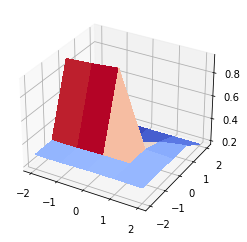

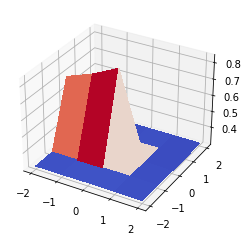

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def run_ibcc(diagonals, base, beta0, gold_labels, crowd_matrix):

    ibcc_model = IBCC(
        L=2, # number of classes
        K=num_workers, 
        alpha0_factor=base,
        alpha0_diags=diagonals,
        beta0_factor=beta0
    )

    # Run inference to obtain an array of size num_data_points x num_classes containing the probabilities of the true labels
    posterior, predictions, _ = ibcc_model.fit_predict(crowd_matrix)
    
    acc = accuracy_score(gold_labels, predictions)
    f1 = f1_score(gold_labels, predictions)
    
    return acc, f1

range_diagonals = np.array([0.01, 0.1, 1, 10, 100])
range_base = np.array([0.01, 0.1, 1, 10, 100])

results_acc = np.zeros((len(range_base), len(range_diagonals)))
results_f1 = np.zeros((len(range_base), len(range_diagonals)))

for i, o in enumerate(range_base):
    for j, d in enumerate(range_diagonals):
        acc, f1 = run_ibcc(d, o, 1, gold_labels, crowd_matrix)
        
        results_acc[i, j] = acc
        results_f1[i, j] = f1

bestbase, bestdiag = np.unravel_index(np.argmax(results_acc), (len(range_base), len(range_diagonals)))
print('Best results: base value={}, diagonal={}, accuracy={}'.format(
    range_base[bestbase],
    range_diagonals[bestdiag],
    results_acc[bestbase, bestdiag]
) )
        
bestbase, bestdiag = np.unravel_index(np.argmax(results_f1), (len(range_base), len(range_diagonals)))
print('Best results: base value={}, diagonal={}, F1 score={}'.format(
    range_base[bestbase],
    range_diagonals[bestdiag],
    results_f1[bestbase, bestdiag]
) )
  
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    np.tile(np.log10(range_base)[None, :], (len(range_diagonals), 1)), 
    np.tile(np.log10(range_diagonals)[:, None], (1, len(range_base))), 
    results_acc,
    cmap=cm.coolwarm,
    linewidth=0, 
    antialiased=False
)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    np.tile(np.log10(range_base)[None, :], (len(range_diagonals), 1)), 
    np.tile(np.log10(range_diagonals)[:, None], (1, len(range_base))), 
    results_f1,
    cmap=cm.coolwarm,
    linewidth=0, 
    antialiased=False
)

Best results: beta0=100.0, accuracy=0.9402099497946144
Best results: beta0=100.0, F1 score=0.84004884004884


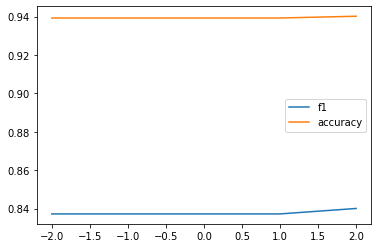

In [22]:
# Do it again, this time varying beta0 and keeping alpha0 fixed
range_proportions = np.array([0.01, 0.1, 1, 10, 100])

results_acc = np.zeros(len(range_proportions))
results_f1 = np.zeros(len(range_proportions))

for i, p in enumerate(range_proportions):
    acc, f1 = run_ibcc(1, 1, p, gold_labels, crowd_matrix)

    results_acc[i] = acc
    results_f1[i] = f1

bestbeta = np.argmax(results_acc)
print('Best results: beta0={}, accuracy={}'.format(
    range_proportions[bestbeta],
    results_acc[bestbeta]
) )
        
bestbeta = np.argmax(results_f1)
print('Best results: beta0={}, F1 score={}'.format(
    range_proportions[bestbeta],
    results_f1[bestbeta]
) )
  
fig = plt.figure()
plt.plot(
    np.log10(range_proportions),
    results_f1,
    label='f1'
)
plt.plot(
    np.log10(range_proportions),
    results_acc,
    label='accuracy'
)

plt.legend(loc='best')



## CrowdLayer

This part explores a model for training neural networks directly from crowdsourced labels, which learns how to weight the contributions from each annotator. This method was proposed in [Rodrigues and Pereira (2018), Deep Learning from Crowds](http://fprodrigues.com//publications/deep-crowds/).  

We will make use of code provided by Filipe Rodrigues. For this part we will need Keras 2. If you don't already have it, you can install it with pip directly by running the command below:

In [17]:
!pip install keras

Next, you need to do the following:
   * Download the GloVe embeddings [from Stanford](http://nlp.stanford.edu/data/glove.6B.zip) and unzip the file into the directory containing this notebook. 
   * Download or pull the CrowdLayer code [from Filipe's Github](https://github.com/fmpr/CrowdLayer) and copy the `crowd_layer` directory into the directory containing this notebook.

In [24]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow import keras
from tensorflow.keras.layers import Embedding

from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy

### Format the data for a Keras text classifier

In [27]:
# join the text and hypothesis into a single sequence, then split into train and validation sets
x_t = textdata["text"].values
x_h = textdata["hypothesis"].values
x = []
for i in range(len(x_t)):
    x.append(x_t[i] + '  ' + x_h[i])  # this simple model doesn't distinguish between text and hypothesis

split_size = 600
train_samples = x[:split_size]
val_samples = x[split_size:]

# Vectorize the text
vectorizer = TextVectorization(max_tokens=2000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [28]:
# apply the vectoriser to the text
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y = textdata["gold"].values
y[y == 'True'] = 1
y[y == 'False'] = 0

y_train = np.array(y[:split_size])
y_val = np.array(y[split_size:])

/Users/es1595/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
/Users/es1595/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [29]:
# create a dictionary that maps word types to embeddings

embedding_size = 50  # select which glove embeddings to use by their dimension
path_to_glove_file = "./glove.6B/glove.6B.{}d.txt".format(embedding_size)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [30]:
# map the words in the text to their embeddings 
num_tokens = len(voc) + 2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 1906 words (94 misses)


### Train neural text classifier on aggregated labels from IBCC

Now we're ready to train a neural network classifier on our task. Let's start by seeing how it does it we take the adjudicated labels from IBCC as a gold standard. This is, roughly speaking, the typical NLP setup for providing training labels.

In [37]:
def add_layers():
    # build a fairly simple binary CNN classifier in Keras
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")

    embedding_layer = Embedding(
        num_tokens,
        embedding_size,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )
    embedded_sequences = embedding_layer(int_sequences_input)

    x = layers.Conv1D(32, 2, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(5)(x)
#     x = layers.Conv1D(64, 5, activation="relu")(x)
#     x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(32, 5, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    preds = layers.Dense(2, activation="softmax")(x)
    
    return int_sequences_input, preds

int_sequences_input, preds = add_layers()

model = keras.Model(int_sequences_input, preds)
model.summary()

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)
print(x_train)
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 50)          100100    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          3232      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056

Let's see the performance figures...

In [38]:
y_val_prob = np.array(model.predict(x_val))
y_val_pred = np.argmax(y_val_prob, axis=1)

show_metrics(y_val, [y_val_prob[:, 1]], [y_val_pred], ["IBCC->CNN"])

Method = IBCC->CNN
Accuracy = 0.53
F1 score = 0.44047619047619047
Cross entropy error = 0.7073165403306484


### Train neural text classifier using CrowdLayer

Now, instead of using the adjudicated labels as training data, we can add an extra layer -- the CrowdLayer -- to the neural network and train directly on the crowdsourced labels. The CrowdLayer applies a kernel to the crowd labels to weight them by annotator ability.

In [40]:
# build a simple binary classifier in Keras
int_sequences_input, preds = add_layers()

# Create a CrowdLayer object
crowd = CrowdsClassification(2, crowd_matrix.shape[1], conn_type="MW")(preds)

# Attach crowd layer on top of the base model
model = keras.Model(int_sequences_input, crowd)
model.summary()

model.compile(
    # a masked loss function is required because we do not have labels from all annotators for all data points
    loss=MaskedMultiCrossEntropy().loss, 
    optimizer="adam"
)

# get the crowd labels for the training set
y_train_crowd = crowd_matrix[textdata.index.values.astype(int)[:split_size], :]
print(y_train_crowd.shape)

# train the model
model.fit(x_train, y_train_crowd, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Tensor("crowds_classification_2/Reshape_2:0", shape=(None, 2, 164), dtype=float32)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 50)          100100    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          3232      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
__________________________________________

### Compute performance metrics

To make predictions, we now need to modify the model by taking the CrowdLayer off again, as we want to predict the true labels, not the crowd labels.

In [46]:
# The current model's output will give us a prediction of the crowd labels.
# To get the true label prediction, we need to go one layer back...
predictions = model.layers[-2].output  

# And recompile the model...
pmodel = keras.Model(inputs=int_sequences_input, outputs=predictions)
pmodel.summary()
pmodel.compile(optimizer='adam', loss='categorical_crossentropy')

# predict on the validation set
y_val_prob = np.array(pmodel.predict(x_val))
print(y_val_prob.shape)
y_val_pred = np.argmax(y_val_prob, axis=1)

#print results
show_metrics(y_val, [y_val_prob[:, 1]], [y_val_pred], ["CNN+CrowdLayer"])

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 50)          100100    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          3232      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                105

Do you see any improvement in the results with the CrowdLayer? The NN is quite basic and its performance varies depending on the random initialisation and random training/validation splits. However, if you repeat the method multiple times, you should see that the CrowdLayer tends to give much better results.